In [3]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
import joblib
import warnings

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)

In [4]:
# Load the project dataset
from prep import preprocess_data

train_df = pd.read_csv('./apache/train_labeled.csv')
test_df = pd.read_csv('./apache/test_labeled.csv')

train_df = preprocess_data(train_df, compact=True)
test_df = preprocess_data(test_df, compact=True)

# check if the columns are the same
if set(train_df.columns) != set(test_df.columns):
    print("Warning: Train and test datasets have different columns.")
    # Print the differences
    train_columns = set(train_df.columns)
    test_columns = set(test_df.columns)
    # get the columns that are in train but not in test
    train_only = train_columns - test_columns
    # get the columns that are in test but not in train
    test_only = test_columns - train_columns
    if train_only:
        print(f"Columns in train but not in test: {train_only}")
    if test_only:
        print(f"Columns in test but not in train: {test_only}")

In [5]:
# Ensure that project_category in both datasets has the same categories
if not train_df['project_category'].equals(test_df['project_category']):
    print("Warning: project_category in train and test datasets do not match.")
    
    train_categories = set(train_df['project_category'].unique())
    test_categories = set(test_df['project_category'].unique())

    # Print the differences
    train_only = train_categories - test_categories
    test_only = test_categories - train_categories
    if train_only:
        print(f"Categories in train but not in test: {train_only}")
    if test_only:
        print(f"Categories in test but not in train: {test_only}")

Categories in train but not in test: {'Geospatial'}


In [6]:
# Encode 'project_category' using data from train_df
oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_encoded = oe.fit_transform(train_df[['project_category']])
test_encoded = oe.transform(test_df[['project_category']])
# Create DataFrames for the encoded categories
train_encoded_df = pd.DataFrame(train_encoded, columns=oe.get_feature_names_out(['project_category']))
test_encoded_df = pd.DataFrame(test_encoded, columns=oe.get_feature_names_out(['project_category']))
# Concatenate the encoded DataFrames with the original DataFrames
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [7]:
# useful columns derived from feature engineering
top_risk_predictors = pd.read_csv('./apache/top_risk_predictors.csv')
schedule_features = top_risk_predictors['Schedule Risk Predictors'].tolist()
quality_features = top_risk_predictors['Quality Risk Predictors'].tolist()

# Filter the DataFrame to keep only the top predictors (plus 'project_category' and the target variable)
schedule_train_df = train_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_train_df = train_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

schedule_test_df = test_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_test_df = test_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

In [8]:
# target = 'schedule_risk'
target = 'quality_risk'

if target == 'schedule_risk':
    train_df = schedule_train_df
    test_df = schedule_test_df
    features = schedule_features
elif target == 'quality_risk':
    train_df = quality_train_df
    test_df = quality_test_df
    features = quality_features

In [9]:
# Prepare data for modeling
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

In [10]:
# 5. Model Training - Baseline Model
target_names = ['Low Risk', 'High Risk']

# Create a Random Forest classifier with default parameters
baseline_rf = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
baseline_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_rf.predict(X_test)

# Evaluate the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Random Forest Accuracy: {baseline_accuracy:.4f}")

# Display classification report
print("\nClassification Report (Baseline Model):")
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

Baseline Random Forest Accuracy: 0.9435

Classification Report (Baseline Model):
              precision    recall  f1-score   support

    Low Risk       0.96      0.97      0.96        90
   High Risk       0.91      0.88      0.90        34

    accuracy                           0.94       124
   macro avg       0.93      0.92      0.93       124
weighted avg       0.94      0.94      0.94       124



In [11]:
# Perform k-fold cross-validation on the baseline model
n_folds = 5
cv_scores = cross_val_score(baseline_rf, X_train, y_train, cv=n_folds, scoring='accuracy')

print(f"\nCross-validation scores (k={n_folds}): {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation scores (k=5): [0.90909091 0.93939394 0.8877551  0.90816327 0.8877551 ]
Mean CV accuracy: 0.9064 ± 0.0189


In [12]:
# 6. Hyperparameter Tuning

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
print("Performing grid search for hyperparameter tuning...")
grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_rf = grid_search.best_estimator_

Performing grid search for hyperparameter tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9146



Best Random Forest Test Accuracy: 0.9516
Improvement over baseline: 0.81%

Classification Report (Best Model):
              precision    recall  f1-score   support

    Low Risk       0.96      0.98      0.97        90
   High Risk       0.94      0.88      0.91        34

    accuracy                           0.95       124
   macro avg       0.95      0.93      0.94       124
weighted avg       0.95      0.95      0.95       124



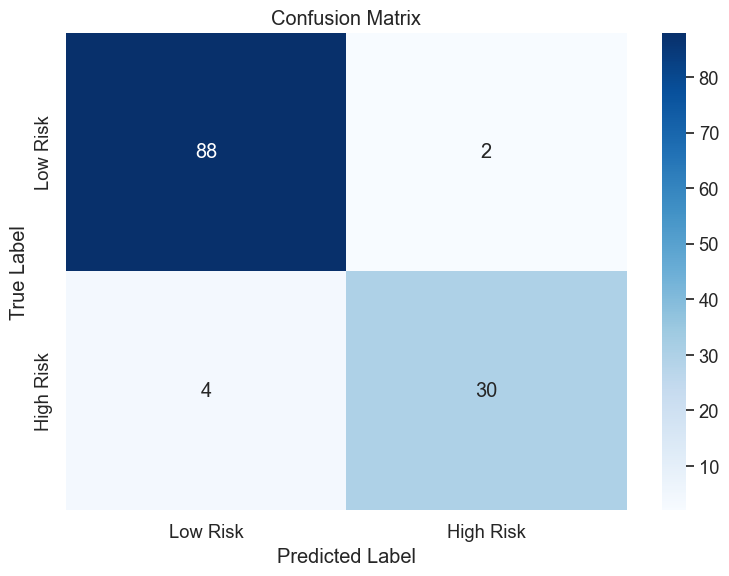

In [11]:
# 7. Model Evaluation with Best Model

# Make predictions on the test set using the best model
y_pred = best_rf.predict(X_test)

# Calculate accuracy
best_accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest Random Forest Test Accuracy: {best_accuracy:.4f}")

# Calculate if there was an improvement over baseline
improvement = (best_accuracy - baseline_accuracy) * 100
print(f"Improvement over baseline: {improvement:.2f}%")

# Display classification report for the best model
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred, target_names=target_names))

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [12]:
# Make probability predictions
y_proba = best_rf.predict_proba(X_test)

# Display probability predictions for the first few samples
prob_df = pd.DataFrame(y_proba, columns=target_names)
prob_df['True Class'] = [target_names[i] for i in y_test]
prob_df['Predicted Class'] = [target_names[i] for i in y_pred]
print("\nProbability predictions for the first 5 test samples:")
print(prob_df.head())


Probability predictions for the first 5 test samples:
   Low Risk  High Risk True Class Predicted Class
0  0.894833   0.105167   Low Risk        Low Risk
1  0.170000   0.830000  High Risk       High Risk
2  0.433643   0.566357  High Risk       High Risk
3  0.934500   0.065500   Low Risk        Low Risk
4  0.236333   0.763667  High Risk       High Risk



Feature Importances:
                                              Feature  Importance
0                             num_priority_high_ratio    0.455045
1                            num_issue_type_bug_ratio    0.079372
2                            bug_to_development_ratio    0.065071
3                           num_priority_medium_ratio    0.043918
13                             num_priority_low_ratio    0.041048
6                        num_resolution_duplicate_pct    0.037553
9                          average_status_change_rate    0.033765
5                                     total_assignees    0.031835
11                                      total_changes    0.030709
7                            num_resolution_fixed_pct    0.030374
10                       average_priority_change_rate    0.029131
8                                    average_workspan    0.028638
4                        num_resolution_won't_fix_pct    0.027723
12                                   resolution_ratio 

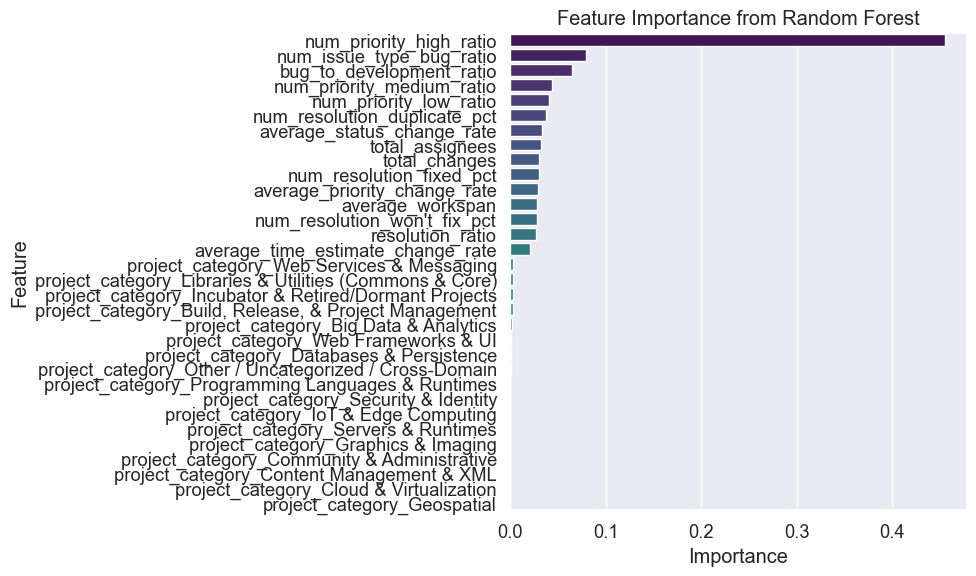

In [13]:
# 8. Feature Importance Analysis

# Get feature importances from the best model
feature_importances = best_rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


Permutation Importances:
                                              Feature  Importance       Std
0                             num_priority_high_ratio    0.269892  0.029939
1                            num_issue_type_bug_ratio    0.030645  0.015498
2                            bug_to_development_ratio    0.015323  0.014921
13                             num_priority_low_ratio    0.010484  0.009347
6                        num_resolution_duplicate_pct    0.009140  0.010356
10                       average_priority_change_rate    0.008333  0.006065
3                           num_priority_medium_ratio    0.008065  0.007213
7                            num_resolution_fixed_pct    0.007796  0.005302
31          project_category_Web Services & Messaging    0.007527  0.002012
5                                     total_assignees    0.004570  0.005383
9                          average_status_change_rate    0.004301  0.007993
12                                   resolution_ratio    0.003

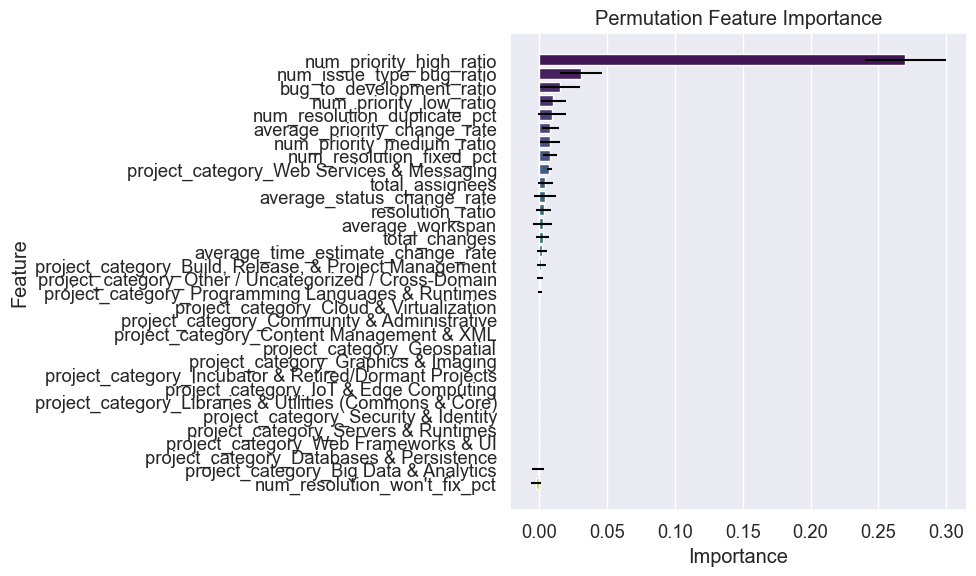

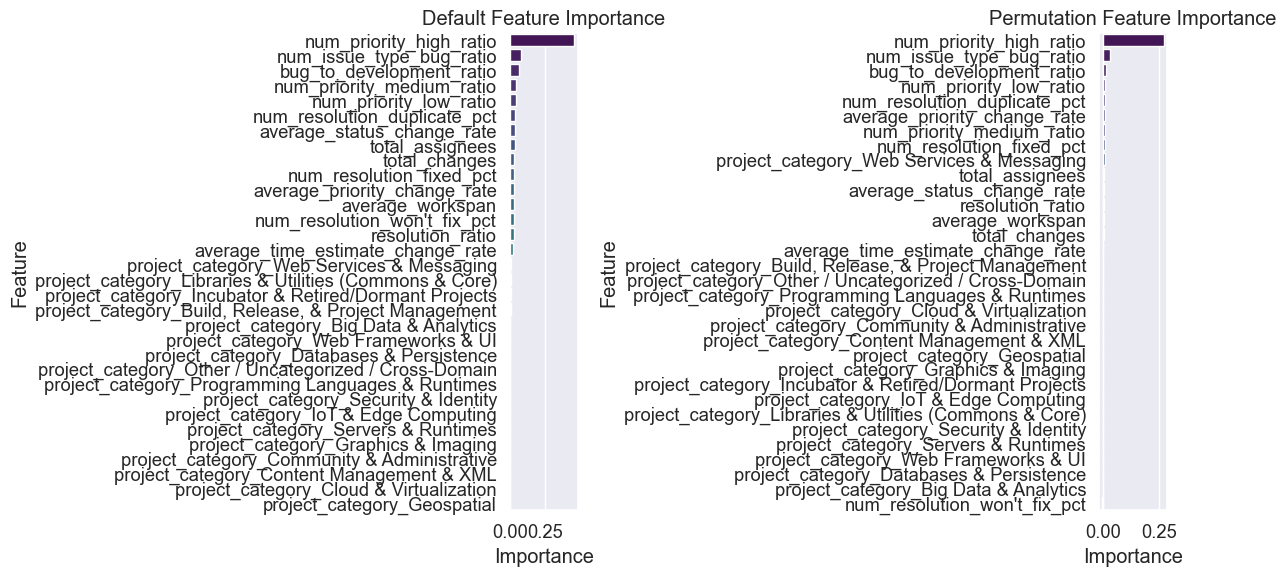

In [14]:
# Calculate permutation importance (another way to measure feature importance)
r = permutation_importance(best_rf, X_test, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': r.importances_mean,
    'Std': r.importances_std
}).sort_values('Importance', ascending=False)

print("\nPermutation Importances:")
print(perm_importance_df)

# Visualize permutation importances with error bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='viridis')
plt.errorbar(x=perm_importance_df.Importance, y=range(len(perm_importance_df)), 
             xerr=perm_importance_df.Std, fmt='none', color='black')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

# Compare the two methods of feature importance
plt.figure(figsize=(12, 6))

# Plot standard feature importance
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Default Feature Importance')

# Plot permutation importance
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='viridis')
plt.title('Permutation Feature Importance')

plt.tight_layout()
plt.show()

In [15]:
# 9. Out-of-Bag Error Analysis

if grid_search.best_params_['bootstrap']:
    print("Bootstrap is enabled, so OOB error can be calculated.")
    # Train a Random Forest model with oob_score=True to get OOB error estimates
    oob_rf = RandomForestClassifier(random_state=42, oob_score=True, **grid_search.best_params_)
    oob_rf.fit(X_train, y_train)

    # Calculate and print OOB score (accuracy)
    print(f"\nOut-of-Bag Score: {oob_rf.oob_score_:.4f}")
    print(f"This represents an estimate of the model's performance without needing a separate test set")

Bootstrap is enabled, so OOB error can be calculated.

Out-of-Bag Score: 0.9024
This represents an estimate of the model's performance without needing a separate test set


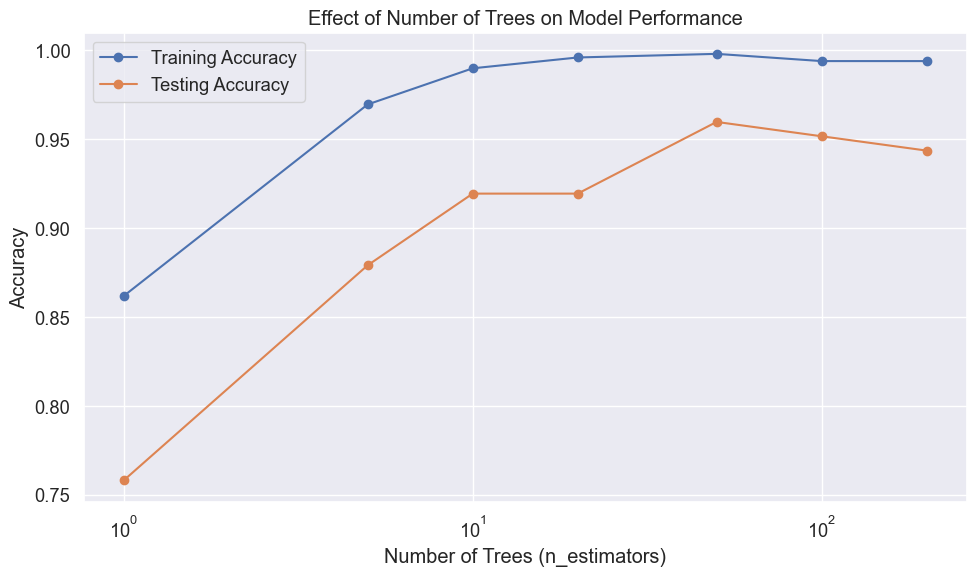

In [16]:
# 10. Analyzing the Effect of Number of Trees

# Train models with different numbers of trees
n_estimators_list = [1, 5, 10, 20, 50, 100, 200]
accuracies_train = []
accuracies_test = []

for n_estimators in n_estimators_list:
    # Create and train model
    rf = RandomForestClassifier(
        n_estimators=n_estimators, 
        random_state=42,
        max_depth=grid_search.best_params_['max_depth'],
        min_samples_split=grid_search.best_params_['min_samples_split'],
        min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
        bootstrap=grid_search.best_params_['bootstrap']
    )
    rf.fit(X_train, y_train)
    
    # Calculate and store accuracy scores
    accuracies_train.append(accuracy_score(y_train, rf.predict(X_train)))
    accuracies_test.append(accuracy_score(y_test, rf.predict(X_test)))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, accuracies_train, 'o-', label='Training Accuracy')
plt.plot(n_estimators_list, accuracies_test, 'o-', label='Testing Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Effect of Number of Trees on Model Performance')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.tight_layout()
plt.show()

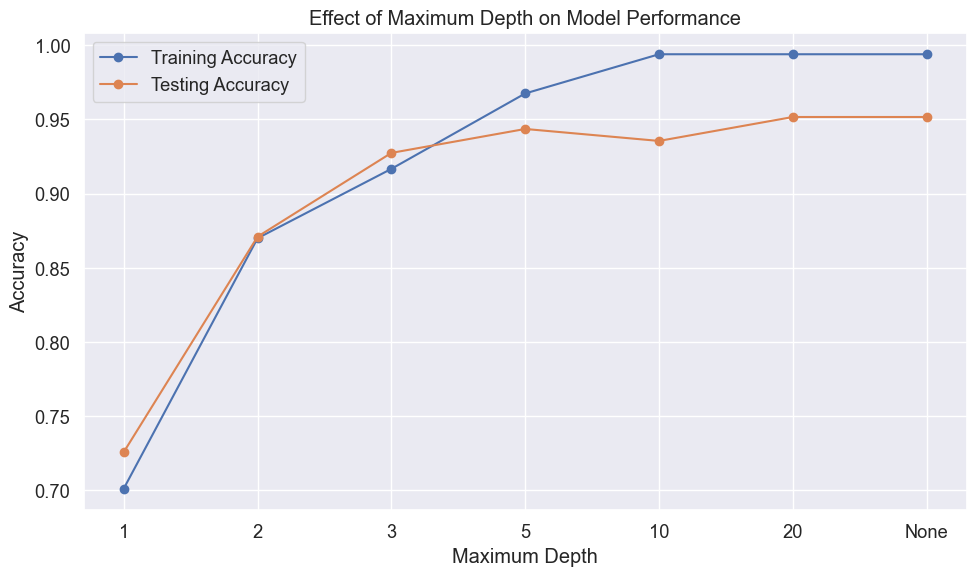

In [17]:
# 11. Analyzing the Effect of Maximum Depth

# Train models with different maximum depths
max_depth_list = [1, 2, 3, 5, 10, 20, None]
accuracies_train = []
accuracies_test = []

for max_depth in max_depth_list:
    # Create and train model
    rf = RandomForestClassifier(
        n_estimators=grid_search.best_params_['n_estimators'],
        max_depth=max_depth, 
        random_state=42,
        min_samples_split=grid_search.best_params_['min_samples_split'],
        min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
        bootstrap=grid_search.best_params_['bootstrap']
    )
    rf.fit(X_train, y_train)
    
    # Calculate and store accuracy scores
    accuracies_train.append(accuracy_score(y_train, rf.predict(X_train)))
    accuracies_test.append(accuracy_score(y_test, rf.predict(X_test)))

# Convert None to 'None' for plotting
max_depth_labels = [str(depth) if depth is not None else 'None' for depth in max_depth_list]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(max_depth_list)), accuracies_train, 'o-', label='Training Accuracy')
plt.plot(range(len(max_depth_list)), accuracies_test, 'o-', label='Testing Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Maximum Depth on Model Performance')
plt.legend()
plt.grid(True)
plt.xticks(range(len(max_depth_list)), max_depth_labels)
plt.tight_layout()
plt.show()

In [18]:
# 12. Model Persistence

# Create directory for models if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = f'models/{target}_random_forest_model.joblib'
joblib.dump(best_rf, model_filename)
print(f"\nModel saved to {model_filename}")

# Example of how to load the model
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
print(f"Loaded model accuracy on test set: {loaded_model.score(X_test, y_test):.4f}")


Model saved to models/quality_risk_random_forest_model.joblib
Model loaded from models/quality_risk_random_forest_model.joblib
Loaded model accuracy on test set: 0.9516


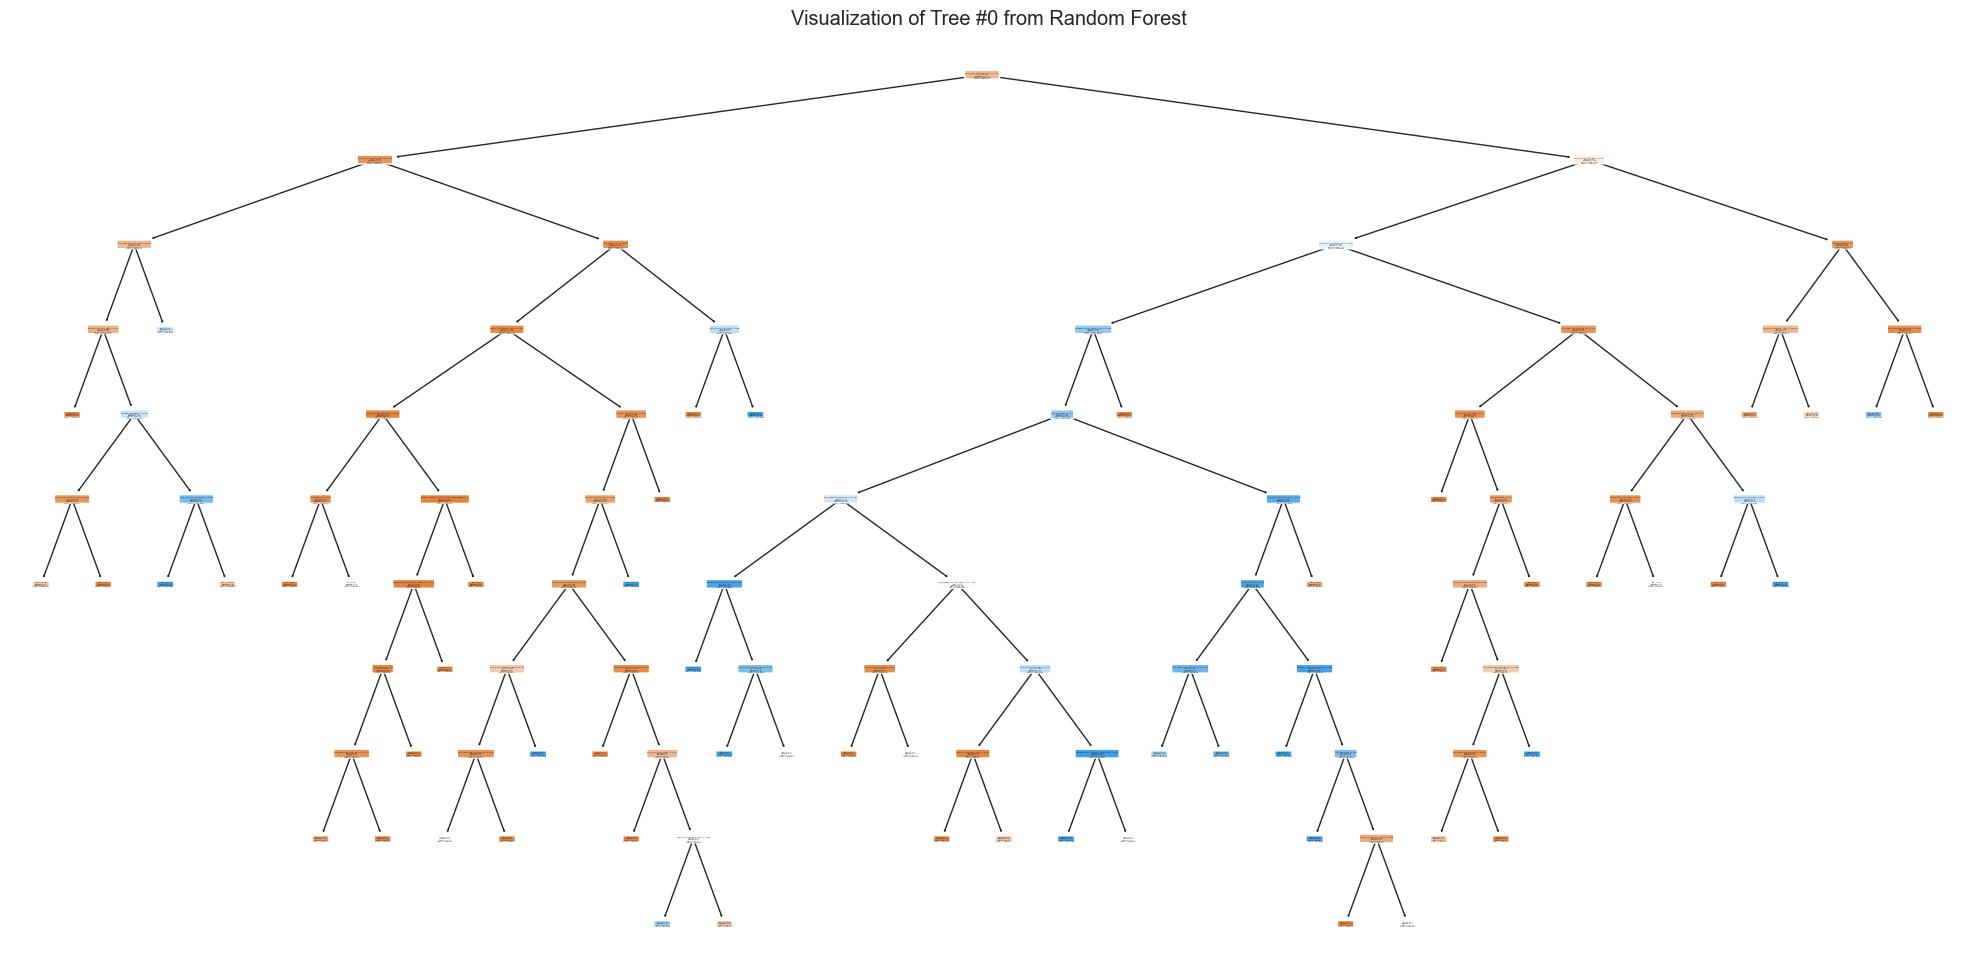

In [19]:
# 13. Visualizing a Single Tree from the Forest

# Extract a single tree from the forest for visualization
# (useful for understanding the structure)
tree_index = 0  # Visualize the first tree in the forest
tree_to_visualize = best_rf.estimators_[tree_index]

# Plot the tree
plt.figure(figsize=(20, 10))
from sklearn import tree as tree_vis
tree_vis.plot_tree(
    tree_to_visualize, 
    feature_names=X_train.columns.tolist(),
    class_names=target_names,
    filled=True, 
    rounded=True
)
plt.title(f'Visualization of Tree #{tree_index} from Random Forest')
plt.tight_layout()
plt.show()

In [1]:
target_names = ['Low Risk', 'High Risk']

In [13]:
# 15. Model Explainability with SHAP (SHapley Additive exPlanations)

# First, we need to install SHAP if it's not already installed
try:
    import shap
except ImportError:
    %pip install shap
    import shap

print("SHAP Analysis for Random Forest Model")
print("====================================")

# Create a SHAP explainer for the random forest model
# TreeExplainer is well-suited for tree-based models including random forests
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Initialize JavaScript visualization
shap.initjs()

SHAP Analysis for Random Forest Model


In [23]:
shap_values.shape

(124, 32, 2)

In [27]:
shap_threshold = 0.01 # Set a threshold for significant SHAP values

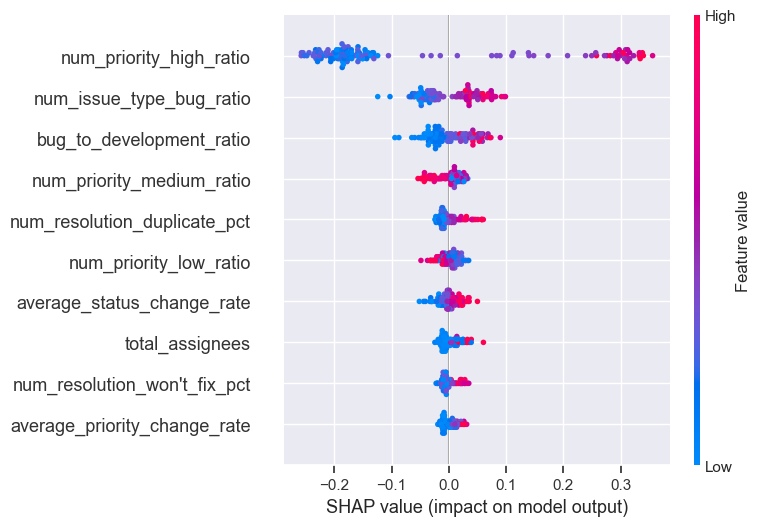

In [28]:
# For binary classification, we only care about the SHAP values for the positive class

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)

# Set threshold (use shap_threshold variable if defined, else set a default)
threshold = shap_threshold if 'shap_threshold' in locals() else 0.05

# Get indices of features above threshold
selected_idx = np.where(mean_abs_shap > threshold)[0]

# Filter SHAP values and feature names
filtered_shap_values = shap_values[:, selected_idx, 1]
filtered_feature_names = X_test.columns[selected_idx]

# summary plot for filtered features
shap.summary_plot(filtered_shap_values, X_test.iloc[:, selected_idx], feature_names=filtered_feature_names, class_names=target_names)

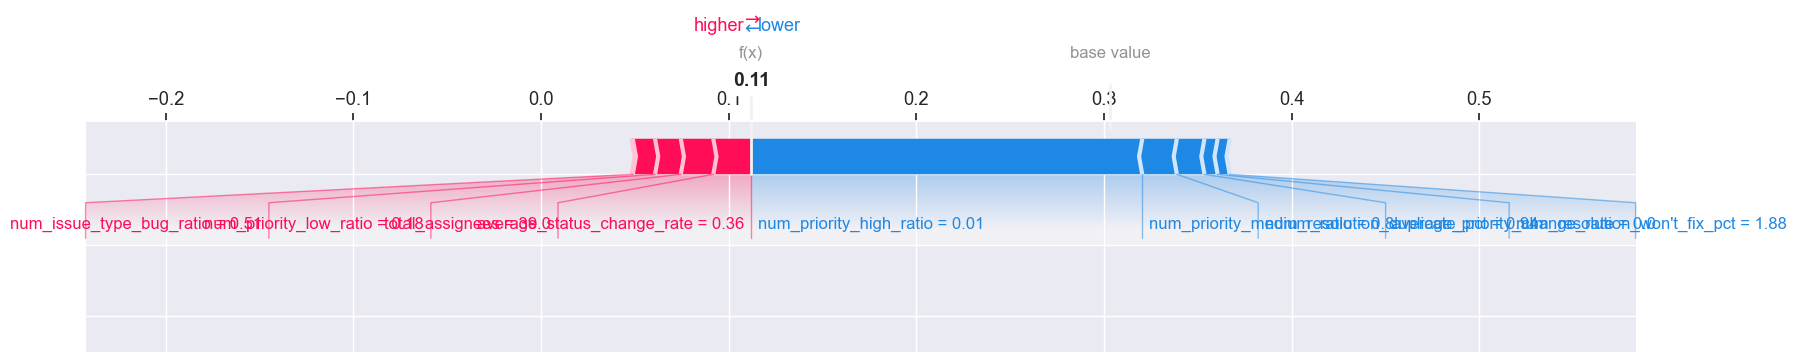

In [33]:
# force plot for the first instance in the test set, filtered by threshold and rounded to 2 decimals

# Calculate mean absolute SHAP values for each feature (for positive class)
mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)
threshold = shap_threshold if 'shap_threshold' in locals() else 0.05
selected_idx = np.where(mean_abs_shap > threshold)[0]

# Filter SHAP values and feature names for the first instance
filtered_shap_values = shap_values[0, selected_idx, 1]
filtered_feature_names = X_test.columns[selected_idx]
filtered_instance = X_test.iloc[0, selected_idx].round(2)

# Show force plot
shap.force_plot(
	explainer.expected_value[1],
	filtered_shap_values,
	filtered_instance,
	feature_names=filtered_feature_names,
	matplotlib=True,
	show=True
)

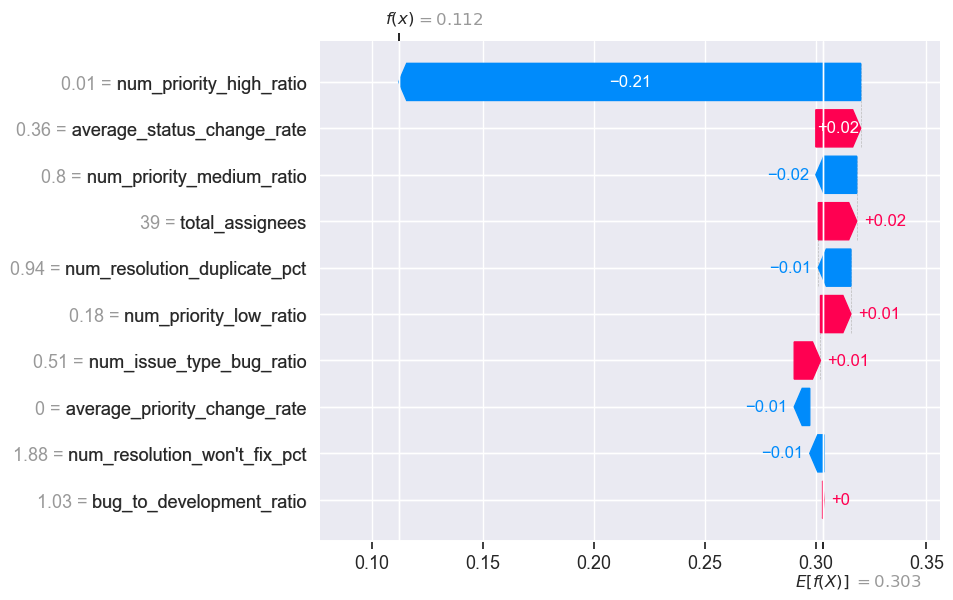

In [35]:
# waterfall plot for the first instance in the test set, filtered by threshold and rounded to 2 decimals
import shap

# Create a SHAP Explanation object for the first instance, positive class
explanation = shap.Explanation(
    values=filtered_shap_values,
    base_values=explainer.expected_value[1],
    data=filtered_instance,
    feature_names=filtered_feature_names
)

shap.waterfall_plot(explanation, max_display=10)

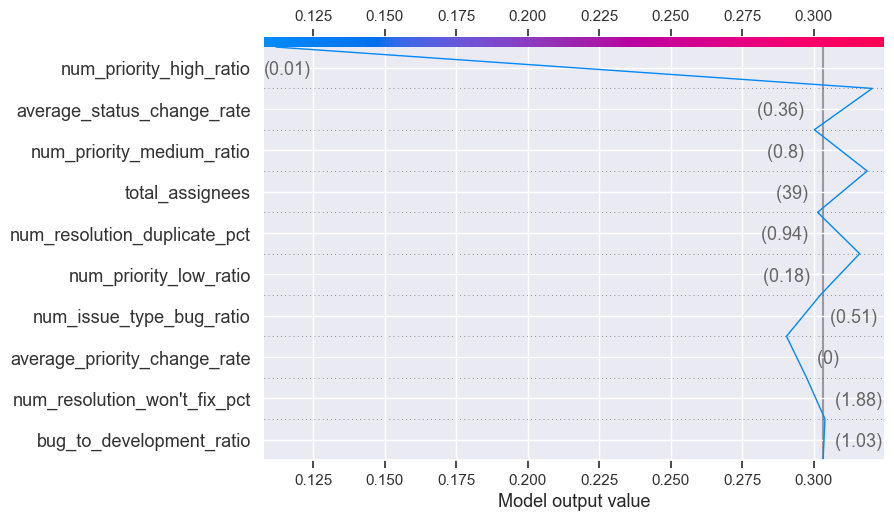

In [37]:
# decision plot for the first instance in the test set, filtered by threshold and rounded to 2 decimals
shap.decision_plot(
    explainer.expected_value[1],
    filtered_shap_values,
    filtered_instance,
    feature_names=filtered_feature_names.tolist(),
    show=True
)